In [9]:
""""""

# Import pandas and numpy
import pandas as pd
import numpy as np
import operator

from settings import NO_OF_GENRES, NO_OF_FEATURES
import load_data
import fuzzy_sets
import gim
from genetic import genetic_optimize, cost_function
from Flowe import flower_pollination_optimize,cost_function

# Constants
WEIGHTS=np.random.rand(NO_OF_FEATURES)
NO_OF_ITERATIONS=100
NO_OF_NEIGHBOURS=25

# namespace items_merged from load_data file
items_merged = load_data.items_merged

# Create objects for Age and GIM to use for fuzzy sets
age = fuzzy_sets.Age()
gim_obj = fuzzy_sets.GIM()

m_cols = ['unknown', 'Action', 'Adventure',
          'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
          'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western', 'age',
          'user_id']

# Initialize empty dataFrames for active and passive users
model_data_active_users = pd.DataFrame(columns=m_cols)
model_data_passive_users = pd.DataFrame(columns=m_cols)


def euclidean_dist(list_a, list_b):
    """Return the Euclidean distance between two array elements."""
    return np.linalg.norm(np.array(list_a) - np.array(list_b))


def fuzzy_dist(first_point, second_point, fuzzy_set_first_point, fuzzy_set_second_point):
    """Returns fuzzy distance between two values and their fuzzy sets."""
    return abs(first_point - second_point) * euclidean_dist(fuzzy_set_first_point, fuzzy_set_second_point)


def fuzzy_distance(ui, uj):
  
    """Returns fuzzy distance between given points."""

    fuzzy_dis = [0] * NO_OF_FEATURES

    # Get fuzzy set values for movie genres
    for i in range(0, NO_OF_GENRES):

        ui_gim = gim_obj.get_fuzzy_set(ui[i])
        uj_gim = gim_obj.get_fuzzy_set(uj[i])
        fuzzy_dis[i] = fuzzy_dist(ui[i], uj[i], ui_gim, uj_gim)

    # Get fuzzy set values for age
    ui_gim = age.get_fuzzy_set(ui[i])
    uj_gim = age.get_fuzzy_set(uj[i])
    fuzzy_dis[i] = fuzzy_dist(ui[i], uj[i], ui_gim, uj_gim)

    # adding user_id of second user
    fuzzy_dis[NO_OF_FEATURES-1] = uj['user_id']
    
    return fuzzy_dis


def get_neighbours(model_active_users, model_passive_users):

    # Save active users and its neighbours in a data-frame with active users' id as column name
    user_neighbours= pd.DataFrame(columns=model_active_users['user_id'])
    #print("user",user_neighbours)
    # Iterate over active users model and save neighbours of each active users in user_neighbours
    for _, value in model_active_users.iterrows():
        j = 0
        fuzzy_vec = []
        for _, value_p in model_passive_users.iterrows():
            fuzzy_vec.append(fuzzy_distance(value, value_p))
            #print("fuzzy_vec",fuzzy_vec)
            #print(WEIGHTS[:-1])
            fuzzy_gen_dist = np.sum(np.multiply(WEIGHTS[:-1], np.array(fuzzy_vec[j][:-1]))) ** 0.5

              
            fuzzy_vec[j] = [fuzzy_gen_dist, fuzzy_vec[j][-1]]

            j = j + 1

        user_neighbours[value[-1]] = [n[1] for n in sorted(fuzzy_vec, key=operator.itemgetter(0), reverse=True)][:NO_OF_NEIGHBOURS]
    return user_neighbours


def model_for_users(users_data):
    """Create model for given users data i.e. merged movies, items, and users

    Args:
        users_data: DataFrame of merged movies, items, and users based on movie_id
    """

    i = 0
    model_data_for_users = pd.DataFrame(columns=m_cols)
    
    for _, curr_value in users_data.iterrows():
        #print(curr_value)
        # Get user movies based on user
        user_movies = items_merged.loc[items_merged['user_id'] == curr_value['user_id']]
        #print("user movie",user_movies)
        # Get feature list for all movies of one user
        feature_array = gim.gim_final(user_movies, curr_value['user_id'])
        feature_array[NO_OF_GENRES] = curr_value['age']
        feature_array[NO_OF_GENRES + 1] = curr_value['user_id']

        # Save current feature values in model data
        model_data_for_users.loc[i] = feature_array
        i = i + 1
    return model_data_for_users


def recommend(nearest_neighbours, test_users_data):
    """Recommend rating for given movies i.e. test_examples based on nearest neighbours.
     
    Also return actual and predicated ratings for testing users
    """
    # print("nearest_neighbours")
    # print(nearest_neighbours)
    # print("test_users_data")
    # print(test_users_data.head())
    predicated_rat=[]
    actual_rat = []
    for key, item in test_users_data.iterrows():
        #print(item)
        
        m_id = item['movie_id']
        n_ratings = []
        for i in nearest_neighbours:

            # Get items or movie details reviewed by neighbour i with given m_id
            temp = items_merged.loc[items_merged['user_id'] == i].loc[items_merged['movie_id'] == m_id]
            for k, it in temp.iterrows():
                n_ratings.append(it['rating'])
        predicated_rat.append(float(sum(n_ratings)) / len(n_ratings) if len(n_ratings) else 0)
        actual_rat.append(item['rating'])
    return actual_rat, predicated_rat

# Users who has rated movies at least 60 movies
top_users = load_data.items_merged.groupby('user_id').size().sort_values(ascending=False)[:497]

model_error = []

# Train model for given iterations
for i in range(0, NO_OF_ITERATIONS):

    # Get random 10% of the top_users as active users and remaining are passive users
    active_users = top_users.sample(frac=0.10)

    # Random 34% of active users will be used for training and 66% users for testing purpose.
    training_active_users = active_users.sample(frac=0.34)
    #testing_active_users = active_users.drop(training_active_users.index)

    # passive_users will be used as training examples
    passive_users = top_users.drop(active_users.index)

    # Get active and passive users' data from merged movies, items, and users
    training_active_users_data = items_merged.loc[items_merged['user_id'].isin(training_active_users)][:10]
    test_active_users_data = items_merged.loc[items_merged['user_id'].isin(training_active_users)][10:]
    passive_users_data = items_merged.loc[items_merged['user_id'].isin(passive_users)][:10]

    # Get model for active users
    model_data_active_users = model_for_users(training_active_users_data)

    # Get model for passive users
    model_data_passive_users = model_for_users(passive_users_data)

    # Get neighbour users of active users
    active_users_neighbours = get_neighbours(model_data_active_users, model_data_passive_users)

    # Recommend users based on neighbours
    actual_ratings, predicated_ratings=recommend(active_users_neighbours, test_active_users_data)

    # Get error for predictions of test users
    cur_error = cost_function(actual_ratings, predicated_ratings)

    # Optimize weights using genetic algorithm approach and update weighs
    #WEIGHTS  =genetic_optimize(actual_ratings, predicated_ratings).flatten()
    
    
    WEIGHTS  =flower_pollination_optimize(actual_ratings, predicated_ratings).flatten()
    # Add current iteration error to model error for MAE of the model
    model_error.append(cost_function(actual_ratings, predicated_ratings))

    # Log details for current iteration
    print("Iteration : ", i)
    print("Error: ", cur_error)
    print('Weights after iteration is: ', WEIGHTS)
print("Mean absolute error for all iterations: ", sum(model_error)/len(model_error))


# Assuming model_error is your list
# replace with your list


/var/folders/pr/xlfhtdlx3gl4h471_mhf__fc0000gn/T/ipykernel_7007/3739413731.py:56: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ui_gim = gim_obj.get_fuzzy_set(ui[i])
/var/folders/pr/xlfhtdlx3gl4h471_mhf__fc0000gn/T/ipykernel_7007/3739413731.py:57: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  uj_gim = gim_obj.get_fuzzy_set(uj[i])
/var/folders/pr/xlfhtdlx3gl4h471_mhf__fc0000gn/T/ipykernel_7007/3739413731.py:58: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
!pip install matplotlib

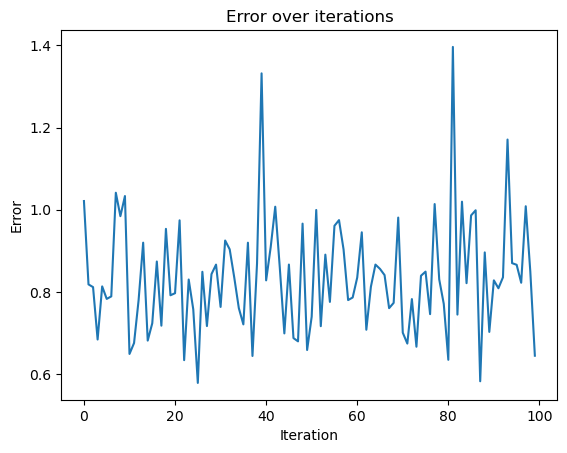

In [ ]:
import matplotlib.pyplot as plt
plt.plot(model_error)
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.title('Error over iterations')
plt.show()

In [ ]:

# Import pandas and numpy
import pandas as pd
import numpy as np
import operator

from settings import NO_OF_GENRES, NO_OF_FEATURES
import load_data
import fuzzy_sets
import gim
from genetic import genetic_optimize, cost_function
from Flowe import flower_pollination_optimize,cost_function

# Constants
WEIGHTS=np.random.rand(NO_OF_FEATURES)
NO_OF_ITERATIONS=100
NO_OF_NEIGHBOURS=25

# namespace items_merged from load_data file
items_merged = load_data.items_merged

# Create objects for Age and GIM to use for fuzzy sets
age = fuzzy_sets.Age()
gim_obj = fuzzy_sets.GIM()

m_cols = ['unknown', 'Action', 'Adventure',
          'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
          'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western', 'age',
          'user_id']

# Initialize empty dataFrames for active and passive users
model_data_active_users = pd.DataFrame(columns=m_cols)
model_data_passive_users = pd.DataFrame(columns=m_cols)


def euclidean_dist(list_a, list_b):
    """Return the Euclidean distance between two array elements."""
    return np.linalg.norm(np.array(list_a) - np.array(list_b))


def fuzzy_dist(first_point, second_point, fuzzy_set_first_point, fuzzy_set_second_point):
    """Returns fuzzy distance between two values and their fuzzy sets."""
    return abs(first_point - second_point) * euclidean_dist(fuzzy_set_first_point, fuzzy_set_second_point)


def fuzzy_distance(ui, uj):
  
    """Returns fuzzy distance between given points."""

    fuzzy_dis = [0] * NO_OF_FEATURES

    # Get fuzzy set values for movie genres
    for i in range(0, NO_OF_GENRES):

        ui_gim = gim_obj.get_fuzzy_set(ui[i])
        uj_gim = gim_obj.get_fuzzy_set(uj[i])
        fuzzy_dis[i] = fuzzy_dist(ui[i], uj[i], ui_gim, uj_gim)

    # Get fuzzy set values for age
    ui_gim = age.get_fuzzy_set(ui[i])
    uj_gim = age.get_fuzzy_set(uj[i])
    fuzzy_dis[i] = fuzzy_dist(ui[i], uj[i], ui_gim, uj_gim)

    # adding user_id of second user
    fuzzy_dis[NO_OF_FEATURES-1] = uj['user_id']
    
    return fuzzy_dis


def get_neighbours(model_active_users, model_passive_users):

    # Save active users and its neighbours in a data-frame with active users' id as column name
    user_neighbours= pd.DataFrame(columns=model_active_users['user_id'])
    #print("user",user_neighbours)
    # Iterate over active users model and save neighbours of each active users in user_neighbours
    for _, value in model_active_users.iterrows():
        j = 0
        fuzzy_vec = []
        for _, value_p in model_passive_users.iterrows():
            fuzzy_vec.append(fuzzy_distance(value, value_p))
            #print("fuzzy_vec",fuzzy_vec)
            #print(WEIGHTS[:-1])
            fuzzy_gen_dist = np.sum(np.multiply(WEIGHTS[:-1], np.array(fuzzy_vec[j][:-1]))) ** 0.5

              
            fuzzy_vec[j] = [fuzzy_gen_dist, fuzzy_vec[j][-1]]

            j = j + 1

        user_neighbours[value[-1]] = [n[1] for n in sorted(fuzzy_vec, key=operator.itemgetter(0), reverse=True)][:NO_OF_NEIGHBOURS]
    return user_neighbours


def model_for_users(users_data):
    """Create model for given users data i.e. merged movies, items, and users

    Args:
        users_data: DataFrame of merged movies, items, and users based on movie_id
    """

    i = 0
    model_data_for_users = pd.DataFrame(columns=m_cols)
    
    for _, curr_value in users_data.iterrows():
        #print(curr_value)
        # Get user movies based on user
        user_movies = items_merged.loc[items_merged['user_id'] == curr_value['user_id']]
        #print("user movie",user_movies)
        # Get feature list for all movies of one user
        feature_array = gim.gim_final(user_movies, curr_value['user_id'])
        feature_array[NO_OF_GENRES] = curr_value['age']
        feature_array[NO_OF_GENRES + 1] = curr_value['user_id']

        # Save current feature values in model data
        model_data_for_users.loc[i] = feature_array
        i = i + 1
    return model_data_for_users


def recommend(nearest_neighbours, test_users_data):
    """Recommend rating for given movies i.e. test_examples based on nearest neighbours.
     
    Also return actual and predicated ratings for testing users
    """
    # print("nearest_neighbours")
    # print(nearest_neighbours)
    # print("test_users_data")
    # print(test_users_data.head())
    predicated_rat=[]
    actual_rat = []
    for key, item in test_users_data.iterrows():
        #print(item)
        
        m_id = item['movie_id']
        n_ratings = []
        for i in nearest_neighbours:

            # Get items or movie details reviewed by neighbour i with given m_id
            temp = items_merged.loc[items_merged['user_id'] == i].loc[items_merged['movie_id'] == m_id]
            for k, it in temp.iterrows():
                n_ratings.append(it['rating'])
        predicated_rat.append(float(sum(n_ratings)) / len(n_ratings) if len(n_ratings) else 0)
        actual_rat.append(item['rating'])
    return actual_rat, predicated_rat

# Users who has rated movies at least 60 movies
top_users = load_data.items_merged.groupby('user_id').size().sort_values(ascending=False)[:497]

model_error = []

# Train model for given iterations
for i in range(0, NO_OF_ITERATIONS):

    # Get random 10% of the top_users as active users and remaining are passive users
    active_users = top_users.sample(frac=0.10)

    # Random 34% of active users will be used for training and 66% users for testing purpose.
    training_active_users = active_users.sample(frac=0.34)
    #testing_active_users = active_users.drop(training_active_users.index)

    # passive_users will be used as training examples
    passive_users = top_users.drop(active_users.index)

    # Get active and passive users' data from merged movies, items, and users
    training_active_users_data = items_merged.loc[items_merged['user_id'].isin(training_active_users)][:10]
    test_active_users_data = items_merged.loc[items_merged['user_id'].isin(training_active_users)][10:]
    passive_users_data = items_merged.loc[items_merged['user_id'].isin(passive_users)][:10]

    # Get model for active users
    model_data_active_users = model_for_users(training_active_users_data)

    # Get model for passive users
    model_data_passive_users = model_for_users(passive_users_data)

    # Get neighbour users of active users
    active_users_neighbours = get_neighbours(model_data_active_users, model_data_passive_users)

    # Recommend users based on neighbours
    actual_ratings, predicated_ratings=recommend(active_users_neighbours, test_active_users_data)

    # Get error for predictions of test users
    cur_error = cost_function(actual_ratings, predicated_ratings)

    # Optimize weights using genetic algorithm approach and update weighs
    WEIGHTS  =flower_pollination_optimize(actual_ratings, predicated_ratings).flatten()
    
    
    #WEIGHTS  =flower_pollination_optimize(actual_ratings, predicated_ratings).flatten()
    # Add current iteration error to model error for MAE of the model
    model_error.append(cost_function(actual_ratings, predicated_ratings))

    # Log details for current iteration
    print("Iteration : ", i)
    print("Error: ", cur_error)
    print('Weights after iteration is: ', WEIGHTS)
print("Mean absolute error for all iterations: ", sum(model_error)/len(model_error))



/var/folders/pr/xlfhtdlx3gl4h471_mhf__fc0000gn/T/ipykernel_7007/3504246880.py:54: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ui_gim = gim_obj.get_fuzzy_set(ui[i])
/var/folders/pr/xlfhtdlx3gl4h471_mhf__fc0000gn/T/ipykernel_7007/3504246880.py:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  uj_gim = gim_obj.get_fuzzy_set(uj[i])
/var/folders/pr/xlfhtdlx3gl4h471_mhf__fc0000gn/T/ipykernel_7007/3504246880.py:56: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
import matplotlib.pyplot as plt
plt.plot(model_error)
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.title('Error over iterations')
plt.show()